In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
from calendar import month_name
from sklearn.preprocessing import MinMaxScaler
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

### Data preprocessing & EDA 

In [2]:
# load data
hotel = pd.read_csv('data/hotel_bookings.csv')
continent = pd.read_csv('data/continents.csv')
pd.set_option('display.max_columns', None)

In [3]:
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
continent.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [5]:
continent.iloc[:,6].unique()

array(['Southern Asia', 'Northern Europe', 'Southern Europe',
       'Northern Africa', 'Polynesia', 'Sub-Saharan Africa',
       'Latin America and the Caribbean', nan, 'Western Asia',
       'Australia and New Zealand', 'Western Europe', 'Eastern Europe',
       'Northern America', 'South-eastern Asia', 'Eastern Asia',
       'Melanesia', 'Micronesia', 'Central Asia'], dtype=object)

In [6]:
continent.isna().sum()

name                          0
alpha-2                       1
alpha-3                       0
country-code                  0
iso_3166-2                    0
region                        1
sub-region                    1
intermediate-region         142
region-code                   1
sub-region-code               1
intermediate-region-code    142
dtype: int64

In [7]:
# convert alpha-2 code to alpha-3 code
hotel['country'].replace('CN', 'CHN', inplace=True)

# add country East timor (TMP) to continent dataset
TMP = {'name':'East Timor', 'alpha-3':'TMP', 'sub-region':'South-eastern Asia' }
continent = continent.append(TMP, ignore_index=True)
# add sub-region ATA to continent dataset
row = int(np.where(continent['alpha-3']=='ATA')[0])
continent.iloc[row,6] = 'Antarctica' 

In [8]:
# add regions to hotel dataset
regions = []
n = 0
for code in hotel['country']:
    # if code == code is False, it is a NaN value
    if (code == code):
        #print(n)
        index = int(np.where(continent['alpha-3'] == code)[0])
        regions.append(continent['sub-region'][index])
    else:
        regions.append(np.nan)
    n += 1
    
hotel['sub_regions'] = regions
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,sub_regions
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Southern Europe
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Southern Europe
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,Northern Europe
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,Northern Europe
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,Northern Europe


Text(0, 0.5, 'Counts')

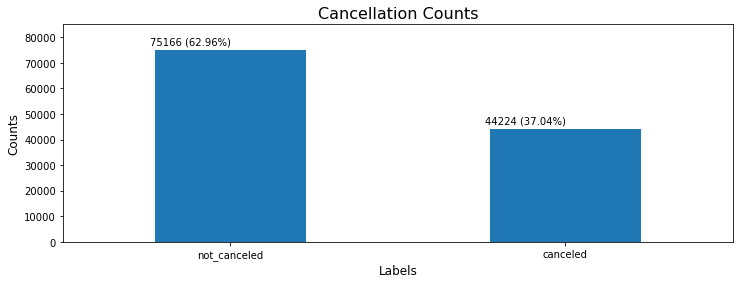

In [9]:
# check data balance
label_counts = np.array(hotel['is_canceled'].value_counts())
label_freqs = np.round(label_counts / label_counts.sum() * 100, 2)

# plot
width = 0.45
index = [0.25, 0.75]

plt.hist(hotel['is_canceled'], bins=2, rwidth=width)
plt.xticks(index, ['not_canceled', 'canceled'])
plt.ylim(0, 85000)
plt.xlim(0, 1)
plt.title('Cancellation Counts', size=16)
plt.annotate('%.f (%.2f%%)' %(label_counts[0], label_freqs[0]), (0.13, 77000))
plt.annotate('%.f (%.2f%%)' %(label_counts[1], label_freqs[1]), (0.63, 46000))
plt.xlabel('Labels', size=12)
plt.ylabel('Counts', size=12)

##### off balance

In [10]:
# check missing data
hotel.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [11]:
# drop company -> too many missing
hotel.drop(columns=['company'], inplace=True)

In [12]:
# fill Na with mode()
# children
child_avg = int(hotel.children.mode()[0])
hotel.children.fillna(child_avg, inplace=True)
# country
country_mode = hotel.country.mode()[0]
hotel.country.fillna(country_mode, inplace=True)
# sub_regions
region_mode = hotel.sub_regions.mode()[0]
hotel.sub_regions.fillna(region_mode, inplace=True)

In [13]:
# check missing data
hotel.isnull().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                               0
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             16340
days_in_waiting_list                  0


##### xgboost can handle missing data. so I will first leave agent as it is now. 

In [14]:
# Add total number of people
hotel['total_num_people'] = hotel['adults'] + hotel['children'] + hotel['babies']

In [15]:
# univariate numerical features outliers analysis
hotel_univar = hotel.describe()
hotel_uT = hotel_univar.T
hotel_uT

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119390.0,0.103886,0.398555,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


###### boxplot needed
lead time, adults, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, ADR, agent, total_num_people

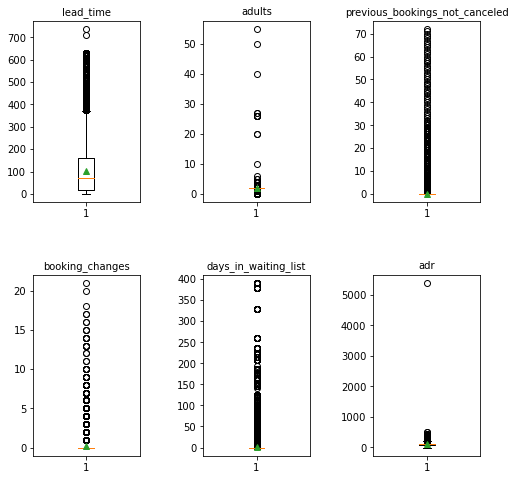

In [16]:
fs = 10

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8), sharey=False)

axes[0, 0].boxplot(hotel['lead_time'], showmeans=True)
axes[0, 0].set_title('lead_time', fontsize=fs)

axes[0, 1].boxplot(hotel['adults'], showmeans=True)
axes[0, 1].set_title('adults', fontsize=fs)

axes[0, 2].boxplot(hotel['previous_bookings_not_canceled'], showmeans=True)
axes[0, 2].set_title('previous_bookings_not_canceled', fontsize=fs)

axes[1, 0].boxplot(hotel['booking_changes'], showmeans=True)
axes[1, 0].set_title('booking_changes', fontsize=fs)

axes[1, 1].boxplot(hotel['days_in_waiting_list'], showmeans=True)
axes[1, 1].set_title('days_in_waiting_list', fontsize=fs)

axes[1, 2].boxplot(hotel['adr'], showmeans=True)
axes[1, 2].set_title('adr', fontsize=fs)



'''
for ax in axes.flatten():
    ax.set_yscale('log')
'''

fig.subplots_adjust(wspace=0.6, hspace=0.4)

In [17]:
hotel2 = hotel.sort_values('adults', ascending=False)
adults_outliers = (list(hotel2.iloc[:3].index))

In [18]:
hotel2 = hotel.sort_values('lead_time', ascending=False)
lead_time_outliers = (list(hotel2.iloc[:2].index))

In [19]:
hotel2 = hotel.sort_values('adr', ascending=False)
adr_outliers = (list(hotel2.iloc[:1].index))

In [20]:
outliers = adults_outliers + lead_time_outliers + adr_outliers
outliers

[2173, 1643, 1539, 1, 4182, 48515]

In [21]:
hotel2.drop(hotel2.index[outliers], inplace=True)

In [22]:
cat_for_plot = []
cat = hotel2.select_dtypes('object').columns.tolist()
for c in cat:
    if c not in ['country', 'reservation_status', 'reservation_status_date']:
        cat_for_plot.append(c)

In [23]:
pd.DataFrame(hotel2[cat[12]].value_counts(normalize=True))
#hotel2.info() 119384

,sub_regions
Southern Europe,0.518336
Western Europe,0.213044
Northern Europe,0.153354
Latin America and the Caribbean,0.024157
Eastern Asia,0.022650
Eastern Europe,0.022499
Northern America,0.017565
Western Asia,0.010362
Sub-Saharan Africa,0.005629
Australia and New Zealand,0.004188


In [ ]:
# univariate categorical features outliers analysis
cat_list = hotel2.select_dtypes('object').columns.tolist()
"""
for i in cat_list:
    print(hotel2[i].value_counts(normalize=True))
    """

In [25]:
hotel2['assigned_room_type'].value_counts(normalize=False)

A    74052
D    25321
E     7806
F     3749
G     2551
C     2375
B     2163
H      712
I      363
K      279
P       12
L        1
Name: assigned_room_type, dtype: int64

##### market undefined, distribution_channel undefined, assigned_room_type L are outliers, therefore can be removed

In [26]:
mar_outlier = list(np.where(hotel2.market_segment == 'Undefined')[0])
dis_outlier = list(np.where(hotel2.distribution_channel == 'Undefined')[0])
rrt_outlier = list(np.where(hotel2.reserved_room_type == 'L')[0])
art_outlier = list(np.where(hotel2.assigned_room_type == 'L')[0])
sub_outlier = list(np.where(hotel2.sub_regions.isin(['Micronesia', 'Polynesia', 'Antarctica', 'Melanesia']))[0])

cat_outliers = mar_outlier + dis_outlier + rrt_outlier + art_outlier + sub_outlier

# drop 23 categorical outliers
hotel2.drop(hotel2.index[cat_outliers], inplace=True)
#print('drop categorical outliers: {}'.format(len(cat_outliers)))

In [27]:
# drop unnecessary features: reservation_status, reservation_status_date
hotel2.drop(columns=['reservation_status', 'reservation_status_date'], inplace=True)

In [28]:
# drop country, because we add regions to reduce dimensions after encoding
hotel2.drop(columns='country', inplace=True)

##### In total, drop 4 columns [company, country, reservation_status, reservation_status_date], add 2 columns [sub_regions, total_num_people]

#### encoding

In [31]:
# convert ordered categorical features to numerical
room_dict = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'K': 10, 'P': 11}
# room type
hotel2.reserved_room_type.replace(room_dict, inplace=True)
hotel2.assigned_room_type.replace(room_dict, inplace=True)
# month
month_lookup = list(month_name)[1:]
month_dict = {}
n = 1
for i in month_lookup:
    month_dict[i] = n
    n += 1
hotel2.arrival_date_month.replace(month_dict, inplace=True)

In [32]:
# convert meal
meal_dict = {'Undefined': 1, 'SC': 1, 'BB': 2, 'HB': 3, 'FB': 4}
hotel2.meal.replace(meal_dict, inplace=True)

In [33]:
# one-hot encoding unordered categorical features
hotel2.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,sub_regions,total_num_people
48515,City Hotel,1,35,2016,3,13,25,0,1,2,0.0,0,2,Offline TA/TO,TA/TO,0,0,0,1,1,1,Non Refund,12.0,0,Transient,5400.0,0,0,Southern Europe,2.0
15083,Resort Hotel,0,1,2015,7,29,15,0,1,2,0.0,0,2,Corporate,Corporate,1,0,1,1,3,0,No Deposit,NaN,0,Transient,508.0,1,0,Southern Europe,2.0
103912,City Hotel,0,81,2016,12,53,31,1,1,2,2.0,0,2,Direct,Direct,0,0,0,5,5,1,No Deposit,NaN,0,Transient-Party,451.5,0,4,Southern Europe,4.0
13142,Resort Hotel,1,378,2017,8,31,1,4,10,2,0.0,0,2,Online TA,TA/TO,0,0,0,1,1,0,No Deposit,314.0,0,Transient,450.0,0,0,Southern Europe,2.0
13391,Resort Hotel,1,59,2017,8,33,13,2,4,2,2.0,0,4,Direct,Direct,0,0,0,8,8,1,No Deposit,250.0,0,Transient,437.0,0,0,Southern Europe,4.0


In [34]:
cat_list2 = hotel2.select_dtypes('object').columns.tolist()
print('unordered categoricals & unique values')
print()
for i in cat_list2:
    print(f'{i}: {len(hotel2[i].unique())}')

unordered categoricals & unique values

hotel: 2
market_segment: 7
distribution_channel: 4
deposit_type: 3
customer_type: 4
sub_regions: 14


In [35]:
print(cat_list2)

['hotel', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type', 'sub_regions']


In [36]:
hotel3 = pd.get_dummies(hotel2, columns=cat_list2, prefix=["hotel", "market", "dist", "deposit", "customer", "region"])

In [38]:
len(hotel3.columns.tolist())

58